## Team Members:
### Varun Biyyala
### Vaibhav Mishra

In [1]:
# Imporing Required Libraries

In [3]:
import os
import cv2
import torchaudio
import torchaudio.transforms as T
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
from torchvision.models.efficientnet import EfficientNet_B3_Weights, EfficientNet_B4_Weights, EfficientNet_B5_Weights

## 1. Converting Audio Files into Images

In [4]:
def audio_to_image(audio_folder, image_folder):
    # List the subfolders in the audio directory
    stress_conditions = os.listdir(audio_folder)

    # Create image folders if they don't exist already
    for condition in stress_conditions:
        os.makedirs(os.path.join(image_folder, condition), exist_ok=True)

    # Process audio files in each stress condition folder
    for condition in stress_conditions:
        audio_path = os.path.join(audio_folder, condition)
        image_path = os.path.join(image_folder, condition)

        # Process each audio file in the current stress condition folder
        for audio_file in os.listdir(audio_path):
            # Load audio file
            waveform, sample_rate = torchaudio.load(os.path.join(audio_path, audio_file))
            # Convert audio to spectrogram
            spec_transform = T.Spectrogram()
            spectrogram = spec_transform(waveform)

            # Reverse the axis - Time(x-axis) & Frequency (y-axis)
            spectrogram = spectrogram.transpose(1, 2)

            # Convert to decibels
            #spectrogram_db = T.AmplitudeToDB()(spectrogram)

            # Convert spectrogram to a numpy array
            spectrogram = spectrogram[0].numpy()

            # Save the spectrogram image in the respective folder
            image_file = os.path.splitext(audio_file)[0] + '.png'
            image_save_path = os.path.join(image_path,f"{condition}_{image_file}")
            plt.imsave(image_save_path, spectrogram, cmap='gray', origin='lower')

In [5]:
# Provide paths to your audio and image folders
audio_folder_path = '/content/drive/MyDrive/PlantSounds/AUDIOFILES'
image_folder_path = '/content/drive/MyDrive/PlantSounds/IMAGEFILES'

In [6]:
# Convert audio files to spectrogram images and save them in respective folders
audio_to_image(audio_folder_path, image_folder_path)

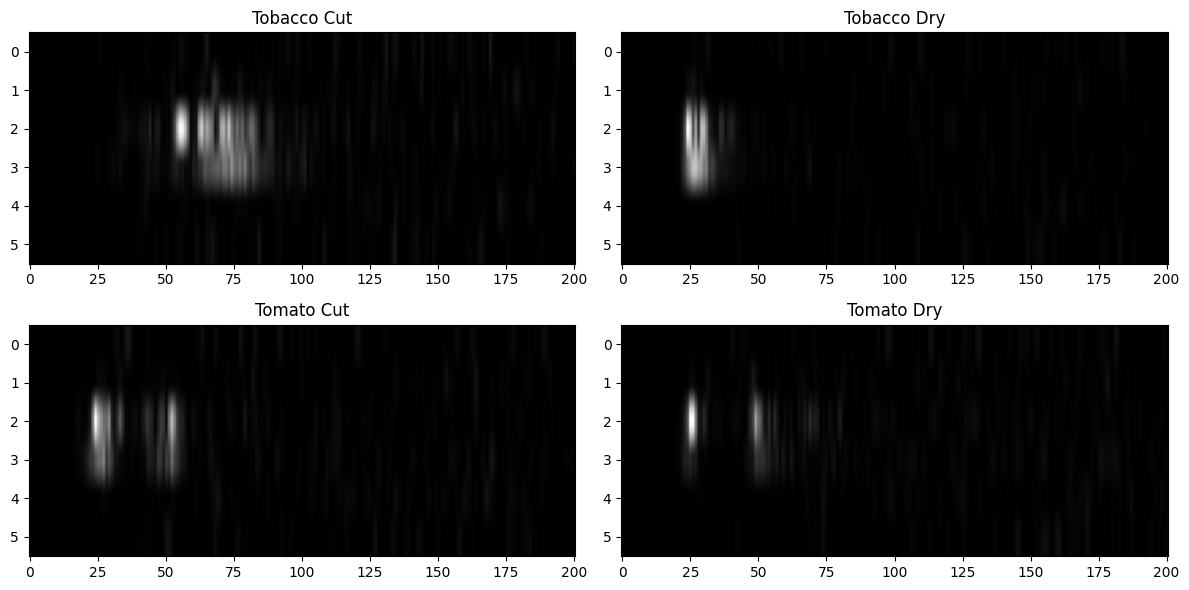

In [6]:
plt.figure(figsize = (12,6))

plt.subplot(2,2,1)
path = '/content/drive/MyDrive/PlantSounds/IMAGEFILES/Tobacco Cut/Tobacco Cut_id_127_sound_10.png'
tobacco_cut = plt.imread(path)
plt.imshow(tobacco_cut, aspect = 'auto')
plt.title('Tobacco Cut')

plt.subplot(2,2,2)
path = '/content/drive/MyDrive/PlantSounds/IMAGEFILES/Tobacco Dry/Tobacco Dry_id_10_sound_1.png'
tobacco_dry = plt.imread(path)
plt.imshow(tobacco_dry, aspect = 'auto')
plt.title('Tobacco Dry')

plt.subplot(2,2,3)
path = '/content/drive/MyDrive/PlantSounds/IMAGEFILES/Tomato Cut/Tomato Cut_id_127_sound_10.png'
tomato_cut = plt.imread(path)
plt.imshow(tomato_cut, aspect = 'auto')
plt.title('Tomato Cut')

plt.subplot(2,2,4)
path = '/content/drive/MyDrive/PlantSounds/IMAGEFILES/Tomato Dry/Tomato Dry_id_101_sound_1.png'
tomato_dry = plt.imread(path)
plt.imshow(tomato_dry, aspect = 'auto')
plt.title('Tomato Dry')

plt.tight_layout()  # Adjusts subplot parameters to fit plots into the figure area
plt.show()

## 2. Defining Denoising Function

In [16]:
# Define denoising function using cv2.fastNlMeansDenoising or other denoising methods
def denoise_image(image):
    # Perform denoising on the image
    denoised_image = cv2.fastNlMeansDenoising(image, None, h=3, templateWindowSize=3, searchWindowSize=5)
    return denoised_image

In [8]:
# Custom transformation for denoising
class DenoiseImage(object):
    def __call__(self, img):
        # Convert PIL image to OpenCV format (numpy array)
        img_np = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        # Apply denoising function
        denoised_img = denoise_image(img_np)
        # Convert back to PIL image
        denoised_img_pil = Image.fromarray(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))
        return denoised_img_pil

In [9]:
# Read the noisy image
noisy_image = cv2.imread('/content/drive/MyDrive/PlantSounds/IMAGEFILES/Tobacco Cut/Tobacco Cut_id_127_sound_10.png')
# Convert to grayscale
denoised_image = denoise_image(noisy_image)

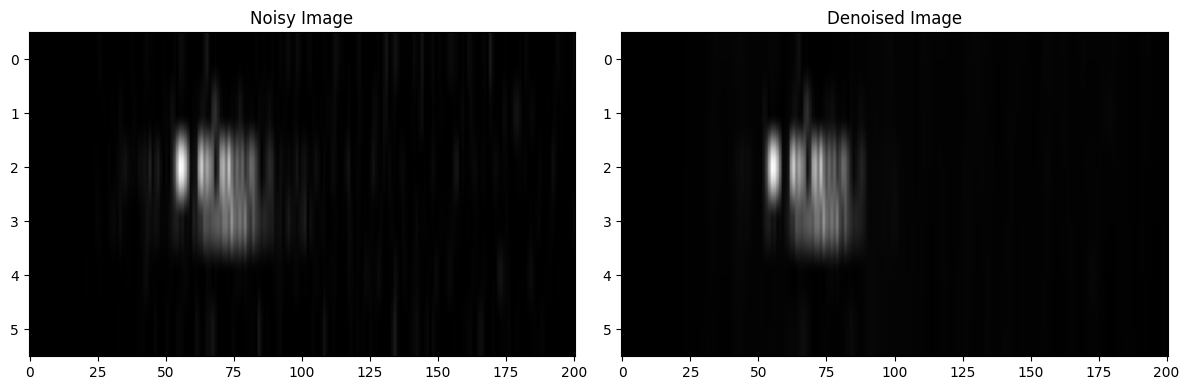

In [10]:
# Display the results using matplotlib
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('Noisy Image')
plt.imshow(noisy_image, cmap='gray', aspect = 'auto')

plt.subplot(1, 2, 2)
plt.title('Denoised Image')
plt.imshow(denoised_image, cmap='gray', aspect = 'auto')

plt.tight_layout()  # Adjusts subplot parameters to fit plots into the figure area
plt.show()

In [14]:
# Define transformations
data_transforms = transforms.Compose([
    DenoiseImage(),  # Apply denoising
    #transforms.Grayscale(num_output_channels=1),# Convert to grayscale
    transforms.Resize((224, 224)),  # Resize the image
    transforms.ToTensor(),  # Convert image to tensor
])

In [12]:
root_dir = '/content/drive/MyDrive/PlantSounds/IMAGEFILES'
folders = os.listdir(root_dir)
folders

['Tomato Cut',
 'Tomato Dry',
 'Tobacco Dry',
 'Greenhouse Noises',
 'Tobacco Cut',
 'Empty Pot']

## 3. Model Architechture - EfficientNet

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.models.efficientnet import EfficientNet_B3_Weights, EfficientNet_B4_Weights, EfficientNet_B5_Weights
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# Function to initialize an EfficientNet model
def initialize_efficientnet(model_name, num_classes):
    if model_name == 'efficientnet_b3':
        weights = EfficientNet_B3_Weights.DEFAULT
        model = models.efficientnet_b3(weights=weights)
    elif model_name == 'efficientnet_b4':
        weights = EfficientNet_B4_Weights.DEFAULT
        model = models.efficientnet_b4(weights=weights)
    elif model_name == 'efficientnet_b5':
        weights = EfficientNet_B5_Weights.DEFAULT
        model = models.efficientnet_b5(weights=weights)
    else:
        raise ValueError('Unknown EfficientNet model: ' + model_name)

    # Replace the classifier
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

## 4. Model Training and Evaluation - 6 Classes

In [17]:


# Define transformations and data augmentation for image preprocessing
data_transforms = transforms.Compose([
    DenoiseImage(),
    transforms.Resize((400, 400)),   # Adjust size according to the variant
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label

# Class indices
class_indices = {
    'Empty Pot': 0,
    'Tobacco Cut': 1,
    'Tobacco Dry': 2,
    'Tomato Cut': 3,
    'Tomato Dry': 4,
    'Greenhouse Noises': 5
}

# Load data and labels
root_dir = '/content/drive/MyDrive/PlantSounds/IMAGEFILES'
data = []
labels = []

for class_name, class_idx in class_indices.items():
    class_dir = os.path.join(root_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        data.append(img)
        labels.append(class_idx)

# Split data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = CustomDataset(train_data, train_labels, transform=data_transforms)
test_dataset = CustomDataset(test_data, test_labels, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize the EfficientNet model
model_name = 'efficientnet_b4'  # Change to 'efficientnet_b4', 'efficientnet_b5', etc.
num_classes = len(class_indices)
model = initialize_efficientnet(model_name, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop with progress bar
epochs = 15
for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', ncols=100)

    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_pbar.set_postfix({'Loss': total_loss / (train_pbar.n + 1)})

    scheduler.step()

# Evaluation loop with progress bar
model.eval()
correct = 0
total = 0
eval_pbar = tqdm(test_loader, desc='Evaluating', ncols=100)

with torch.no_grad():
    for inputs, labels in eval_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        eval_pbar.set_postfix({'Accuracy': f'{accuracy:.2f}%'})

accuracy = 100 * correct / total
print(f'\nAccuracy of {model_name} on the test set: {accuracy:.2f}%')

# Save the trained model
model_file_path = f"{model_name}_model.pth"
torch.save(model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")


Evaluating: 100%|██████████████████████████████████| 69/69 [00:09<00:00,  6.95it/s, Accuracy=76.19%]



Accuracy of efficientnet_b4 on the test set: 76.19%
Model saved to efficientnet_b4_model.pth


## 5. Performance Test for "Tomato Cut vs Greenhouse Noises"

In [18]:
data = []
labels = []
filenames = []

folders_to_load = ['Tomato Cut', 'Greenhouse Noises']  # Define the folders to load

for folder in folders_to_load:
    folder_path = os.path.join(root_dir, folder)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        data.append(img)
        labels.append(folder)
        filenames.append(filename)

In [21]:
# Renaming Labels with Integers
class_indices = {
    'Tomato Cut': 0,
    'Greenhouse Noises': 1
}
# Convert label names to class indices
labels = [class_indices[label] for label in labels]

In [22]:
# Split data into train and test sets (80% train, 20% test)
train_data, test_data, train_labels, test_labels, train_filenames, test_filenames = train_test_split(
    data, labels, filenames, test_size=0.2, random_state=42, stratify=labels
)

In [23]:
# Create train and test datasets
train_dataset = CustomDataset(train_data, train_labels, transform=data_transforms)
test_dataset = CustomDataset(test_data, test_labels, transform=data_transforms)

In [24]:
# Define batch size
batch_size = 16

# Create DataLoader objects
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [25]:
# Function to initialize an EfficientNet model
def initialize_efficientnet(model_name, num_classes):
    if model_name == 'efficientnet_b3':
        weights = EfficientNet_B3_Weights.DEFAULT
        model = models.efficientnet_b3(weights=weights)
    elif model_name == 'efficientnet_b4':
        weights = EfficientNet_B4_Weights.DEFAULT
        model = models.efficientnet_b4(weights=weights)
    elif model_name == 'efficientnet_b5':
        weights = EfficientNet_B5_Weights.DEFAULT
        model = models.efficientnet_b5(weights=weights)
    else:
        raise ValueError('Unknown EfficientNet model: ' + model_name)

    # Replace the classifier
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# Define transformations and data augmentation for image preprocessing
data_transforms = transforms.Compose([
    DenoiseImage(),
    transforms.Resize((400, 400)),   # Adjust size according to the variant
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        if self.transform:
            img = self.transform(img)
        return img, label




# Initialize the EfficientNet model
model_name = 'efficientnet_b4'  # Change to 'efficientnet_b4', 'efficientnet_b5', etc.
num_classes = len(class_indices)
model = initialize_efficientnet(model_name, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

# Training loop with progress bar
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', ncols=100)

    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        train_pbar.set_postfix({'Loss': total_loss / (train_pbar.n + 1)})

    scheduler.step()

# Evaluation loop with progress bar
model.eval()
correct = 0
total = 0
eval_pbar = tqdm(test_loader, desc='Evaluating', ncols=100)

with torch.no_grad():
    for inputs, labels in eval_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        eval_pbar.set_postfix({'Accuracy': f'{accuracy:.2f}%'})

accuracy = 100 * correct / total
print(f'\nAccuracy of {model_name} on the test set: {accuracy:.2f}%')

# Save the trained model
model_file_path = f"{model_name}_model.pth"
torch.save(model.state_dict(), model_file_path)
print(f"Model saved to {model_file_path}")


Evaluating: 100%|██████████████████████████████████| 26/26 [00:03<00:00,  6.80it/s, Accuracy=98.77%]



Accuracy of efficientnet_b4 on the test set: 98.77%
Model saved to efficientnet_b4_model.pth


### Research Paper Link

https://www.researchgate.net/publication/376685059_Enhancing_Plant_Stress_Detection_through_Denoising_of_Audio_Signals_and_Advanced_Classification_Models

### Model File Link

https://drive.google.com/file/d/1r9E_4b_1_SwnUY5K-LL8Vjj9PIk0VM12/view?usp=sharing

### Dataset Link

https://drive.google.com/drive/folders/101xgZQ50q9Fsv3T66WZfyXj2jS1D0Do1?usp=drive_link